In [43]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from src.autoencoders import Autoencoder, VariationalAutoEncoder
from utils.mnist_loader import data_download, data_loader
from utils.model_trainer import autoencoder_trainer, vae_trainer
from utils.visualization import visualization

In [44]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 100
SAMPLES = 5
print(DEVICE)
train_data, test_data = data_download()
train_loader, test_loader = data_loader(train_data, test_data, batch_size=256)

cuda
number of training data :  60000
number of test data :  10000


In [51]:
def vae_loss(reconstruction, x, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, x, reduction='sum') # bernoulli distribution assumption
    kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss, kl_loss

# Beta-Variational Autoencoder

In [52]:
b_vae = VariationalAutoEncoder(n_hidden=336, z_dim=2).to(DEVICE)
optimizer = torch.optim.Adam(b_vae.parameters(), lr=0.001)
criteria = vae_loss

In [5]:
train_loss, test_loss = vae_trainer(model=b_vae, beta=4,
                                    criteria=criteria, optimizer=optimizer, 
                                    train_loader=train_loader, test_loader=test_loader, 
                                    device=DEVICE, epochs = EPOCHS)

  1%|          | 1/100 [00:06<10:32,  6.38s/it]

epochs: 1 - Train loss: 202.663818359375 - Test loss: 199.68344116210938
Test Error Ratio || reconstruction error: 196.4862060546875 , KLD: 0.7993078231811523


 11%|█         | 11/100 [00:54<07:03,  4.76s/it]

epochs: 11 - Train loss: 174.5442352294922 - Test loss: 178.37164306640625
Test Error Ratio || reconstruction error: 164.11825561523438 , KLD: 3.5633487701416016


 21%|██        | 21/100 [01:44<06:45,  5.13s/it]

epochs: 21 - Train loss: 171.50027465820312 - Test loss: 164.0880889892578
Test Error Ratio || reconstruction error: 148.8056640625 , KLD: 3.8206076622009277


 31%|███       | 31/100 [02:36<05:58,  5.20s/it]

epochs: 31 - Train loss: 176.68569946289062 - Test loss: 184.95880126953125
Test Error Ratio || reconstruction error: 168.7995147705078 , KLD: 4.039822578430176


 41%|████      | 41/100 [03:29<05:02,  5.12s/it]

epochs: 41 - Train loss: 149.6680908203125 - Test loss: 196.51333618164062
Test Error Ratio || reconstruction error: 178.9075927734375 , KLD: 4.401433944702148


 51%|█████     | 51/100 [04:21<04:15,  5.21s/it]

epochs: 51 - Train loss: 171.9013671875 - Test loss: 170.89358520507812
Test Error Ratio || reconstruction error: 154.47178649902344 , KLD: 4.105451583862305


 61%|██████    | 61/100 [05:13<03:24,  5.24s/it]

epochs: 61 - Train loss: 161.6387939453125 - Test loss: 161.9122314453125
Test Error Ratio || reconstruction error: 141.44984436035156 , KLD: 5.115596771240234


 71%|███████   | 71/100 [06:05<02:31,  5.22s/it]

epochs: 71 - Train loss: 167.5308380126953 - Test loss: 139.77232360839844
Test Error Ratio || reconstruction error: 119.83311462402344 , KLD: 4.984801769256592


 81%|████████  | 81/100 [06:57<01:39,  5.21s/it]

epochs: 81 - Train loss: 157.22830200195312 - Test loss: 156.39309692382812
Test Error Ratio || reconstruction error: 137.87759399414062 , KLD: 4.628875732421875


 91%|█████████ | 91/100 [07:49<00:46,  5.22s/it]

epochs: 91 - Train loss: 160.02590942382812 - Test loss: 163.25888061523438
Test Error Ratio || reconstruction error: 143.97608947753906 , KLD: 4.8206987380981445


100%|██████████| 100/100 [08:36<00:00,  5.17s/it]


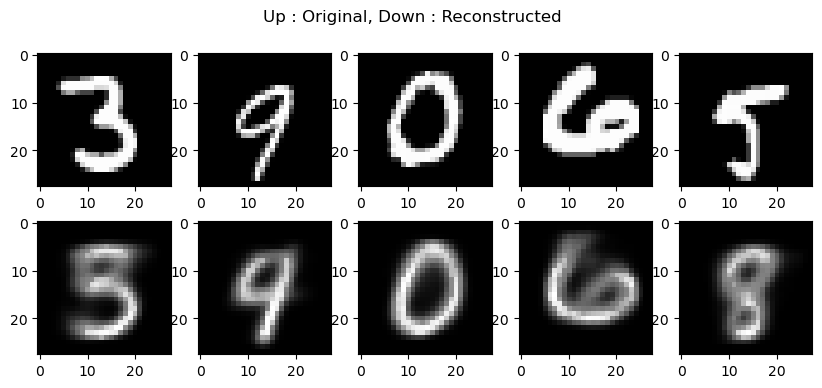

In [6]:
visualization(loader=test_loader, model=b_vae, device=DEVICE, num_of_samples=SAMPLES)

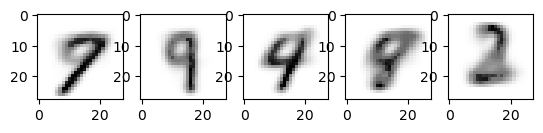

In [7]:
b_vae.cpu()
generated_samples = b_vae.generate(SAMPLES)

for i, sample in enumerate(generated_samples):
    plt.subplot(1, SAMPLES, i+1)
    plt.imshow(sample.reshape(28, 28), cmap='gray_r')
plt.show()

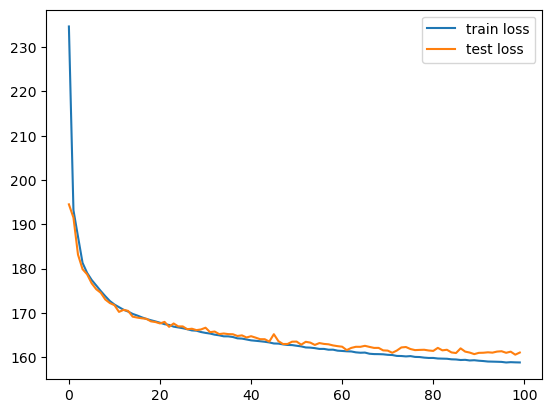

In [8]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()
plt.show()

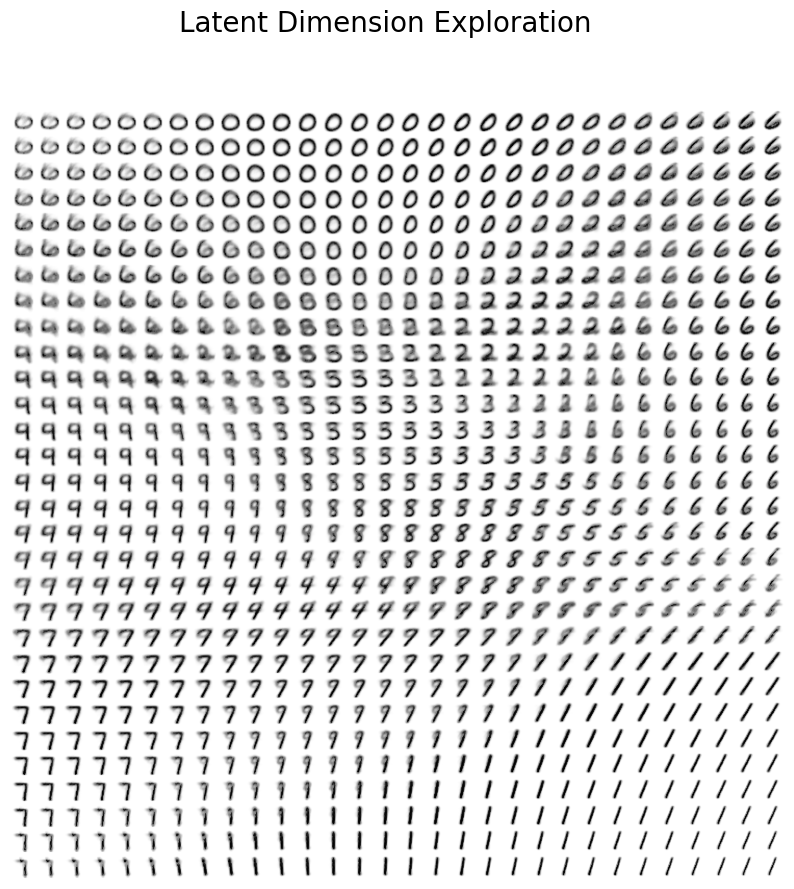

In [9]:
steps = 30
scope = 2.
xs = torch.linspace(scope, -scope, steps)
ys = torch.linspace(scope, -scope, steps)
x, y = torch.meshgrid(xs, ys, indexing='xy')
images = b_vae.decoder(torch.stack([x, y], dim=0).reshape(2, steps**2).T).view(-1, 28, 28)

fig = plt.figure(figsize=(10,10))
ax = [plt.subplot(steps, steps, i+1) for i in range(steps**2)]
for i, image in enumerate(images):
    ax[i].imshow(image.detach().numpy(), cmap='gray_r')
    ax[i].axis('off')
    ax[i].set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Latent Dimension Exploration',fontsize=20)
plt.show()


# CelebA Dataset

In [31]:
import torchvision
import torch

In [107]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64,64), antialias=True)
])

celeb_dataset = torchvision.datasets.ImageFolder(
    root='../dataset/CelebA',
    transform=transform,
    target_transform=None
)

In [108]:
train_data, test_data = torch.utils.data.random_split(celeb_dataset, [len(celeb_dataset)-1024, 1024])
train_loader, test_loader = data_loader(train_data, test_data, batch_size=256)

In [109]:
encoder = nn.Sequential(
    nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
    nn.Flatten(), nn.Linear(8*8*64, 256)
)

decoder = nn.Sequential(
    nn.Linear(32, 6*6*64), nn.ReLU(),
    nn.Unflatten(-1, (64, 6, 6)),
    nn.ConvTranspose2d(64, 32, 4, 2), nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 5, 2), nn.ReLU(),
    nn.ConvTranspose2d(32, 3, 4, 2), nn.Sigmoid() # bernoulli assumed
)

In [110]:
encoder(x[0].unsqueeze(0))

tensor([[-0.0147, -0.0171, -0.0075, -0.0183, -0.0214,  0.0173, -0.0090, -0.0233,
         -0.0356,  0.0165, -0.0115, -0.0221,  0.0023,  0.0370,  0.0026, -0.0038,
         -0.0104, -0.0180, -0.0056,  0.0447, -0.0133,  0.0174,  0.0114,  0.0013,
         -0.0181, -0.0251, -0.0071, -0.0104,  0.0077, -0.0099, -0.0157, -0.0573,
          0.0049, -0.0123,  0.0145,  0.0421,  0.0072, -0.0244,  0.0234,  0.0228,
          0.0129,  0.0054,  0.0308, -0.0036,  0.0148, -0.0057, -0.0078,  0.0199,
          0.0446, -0.0005,  0.0174,  0.0274, -0.0225,  0.0033, -0.0191, -0.0496,
          0.0036, -0.0024,  0.0146, -0.0398,  0.0136,  0.0019, -0.0289,  0.0191,
          0.0008,  0.0112,  0.0381, -0.0057,  0.0014,  0.0059, -0.0297, -0.0121,
          0.0154,  0.0033,  0.0061, -0.0177,  0.0343, -0.0140,  0.0159,  0.0039,
         -0.0287, -0.0264,  0.0161,  0.0168,  0.0146, -0.0013,  0.0237,  0.0139,
         -0.0093, -0.0120,  0.0012, -0.0019, -0.0305, -0.0231, -0.0109,  0.0291,
         -0.0252, -0.0357,  

In [119]:
vae = VariationalAutoEncoder(encoder=encoder, decoder=decoder, n_hidden=256, z_dim=32).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
criteria = vae_loss

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [124]:
train_loss, test_loss = vae_trainer(model=vae, beta=1,
                                    criteria=criteria, optimizer=optimizer, 
                                    train_loader=train_loader, test_loader=test_loader, 
                                    device=DEVICE, epochs = EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([256, 3, 64, 64])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [123]:
import tqdm
def vae_trainer(model, criteria, optimizer, train_loader,
                test_loader, device, epochs, beta=1):
    
    train_loss_hist = []
    test_loss_hist = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        train_loss = []
        test_loss = []
        for x, _ in train_loader:
            print(x.shape)
            x = x.to(device)
            print(x.shape)
            model.train()
            mu, logvar, reconstruct = model(x)
            reconstruction_loss, kl_loss = criteria(reconstruct, x, mu, logvar)
            reconstruction_loss = reconstruction_loss / x.shape[0]
            kl_loss = kl_loss / x.shape[0]
            loss = reconstruction_loss + beta * kl_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss_hist.append(torch.tensor(train_loss).mean())
        
        model.eval()
        for x, _ in test_loader:
            x = x.to(device)
            mu, logvar, reconstruct = model(x)
            reconstruction_loss, kl_loss = criteria(reconstruct, x, mu, logvar)
            reconstruction_loss = reconstruction_loss / x.shape[0]
            kl_loss = kl_loss / x.shape[0]
            loss = reconstruction_loss + beta * kl_loss
            test_loss.append(loss.item())
        test_loss_hist.append(torch.tensor(test_loss).mean())
        
        if epoch % 10 == 0:     
            print(f'epochs: {epoch + 1} - Train loss: {train_loss[-1]} - Test loss: {test_loss[-1]}')
            print(f'Test Error Ratio || reconstruction error: {reconstruction_loss} , KLD: {kl_loss}')
    return train_loss_hist, test_loss_hist
